In [43]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import numpy as np
import cv2
import pandas as pd
import glob
import random
import matplotlib.pyplot as plt
import os

In [29]:
learning_rate = 0.001
batch_size = 10
epochs = 10


device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

In [34]:
train_path = 'C:/Users/sgold/laba5/train'
test_path = 'C:/Users/sgold/laba5/test'
val_path = 'C:/Users/sgold/laba5/val'
path_to_dataset=r"C:/Users/sgold/laba5/dataset/"

df = pd.read_csv(os.path.join(path_to_dataset, "C:/Users/sgold/laba5/dataset_csv.csv"), header=None, delimiter=";", names=['path_to_image', 'label'])
if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)

def train_loading(df, path, i):
    image_path = df.path_to_image[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{df.label[i]}.{i}.jpg'), image)

def test_loading(df, path, i):
    image_path = df.path_to_image[i]
    image = cv2.imread(image_path)
    if i - 880 > 109: 
        i = i - 1870
    else:
        i = i - 880
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)

for i in range(880):
    train_loading(df, train_path, i)

for i in range(880, 990):
    train_loading(df, test_path, i)

for i in range(990, 1100):
    train_loading(df, val_path, i)

for i in range(1100, 1980):
    train_loading(df, train_path, i)

for i in range(1980, 2090):
    train_loading(df, test_path, i)

for i in range(2090, 2200):
    train_loading(df, val_path, i)
    

train_list = glob.glob(os.path.join(train_path,'*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))
train_list, val_list = train_test_split(train_list, test_size=0.1)
    

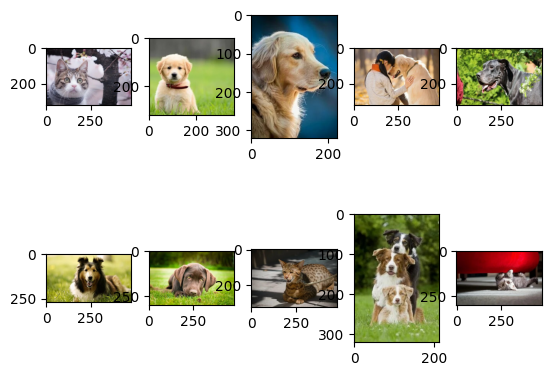

In [35]:
random_idx = np.random.randint(1,200,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = cv2.imread(train_list[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i+=1

plt.show()

In [50]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [76]:
from PIL import Image

class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('\\')[-1].split('.')[0]
        
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
            
        return img_transformed,label


train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

In [77]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out


In [78]:
model = Cnn().to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [79]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [80]:
print('Learning rate: 0.001, Batch size: 10')

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

epochs = 20

def train_loop (train_loader, val_loader, epochs):
    val_loss_list = []
    val_accuracy_list = []

    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in train_loader:
            data = torch.tensor(data).to(device)
            label = torch.tensor(label).to(device)
            
            output = model(data)
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)

        loss_list.append(epoch_loss.item())
        accuracy_list.append(epoch_accuracy.item())

        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        
        
        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0

            for data, label in val_loader:
                data = torch.tensor(data).to(device)
                label = torch.tensor(label).to(device)
                
                val_output = model(data)
                val_loss = criterion(val_output,label)
                
                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)

            
            val_loss_list.append(epoch_val_loss.item())
            val_accuracy_list.append(epoch_val_accuracy.item())
                
            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
    

    num_epochs = [i+1 for i in range(epochs)]

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for train')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1,2,1)
    plt.plot(num_epochs, loss_list, label = 'loss') 
    fig.add_subplot(1,2,2)
    plt.plot(num_epochs, accuracy_list, label = 'accuracy')

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for valid')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1,2,1)
    plt.plot(num_epochs, val_loss_list, label = 'loss')
    fig.add_subplot(1,2,2)


Learning rate: 0.001, Batch size: 10


C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, train accuracy : 0.5657232999801636, train loss : 0.683384120464325


C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, val_accuracy : 0.635185182094574, val_loss : 0.6619083881378174
Epoch : 2, train accuracy : 0.6286165714263916, train loss : 0.6409809589385986
Epoch : 2, val_accuracy : 0.6481481194496155, val_loss : 0.6178485751152039
Epoch : 3, train accuracy : 0.6657233238220215, train loss : 0.613868772983551
Epoch : 3, val_accuracy : 0.6444445252418518, val_loss : 0.6249839067459106
Epoch : 4, train accuracy : 0.686163604259491, train loss : 0.5880493521690369
Epoch : 4, val_accuracy : 0.6814814805984497, val_loss : 0.5964401364326477
Epoch : 5, train accuracy : 0.6864780187606812, train loss : 0.582508385181427
Epoch : 5, val_accuracy : 0.6425926089286804, val_loss : 0.6196439266204834
Epoch : 6, train accuracy : 0.7062895894050598, train loss : 0.5754392743110657
Epoch : 6, val_accuracy : 0.6944444179534912, val_loss : 0.5741825699806213
Epoch : 7, train accuracy : 0.7176101803779602, train loss : 0.5457889437675476
Epoch : 7, val_accuracy : 0.7555555701255798, val_loss : 0.539713621

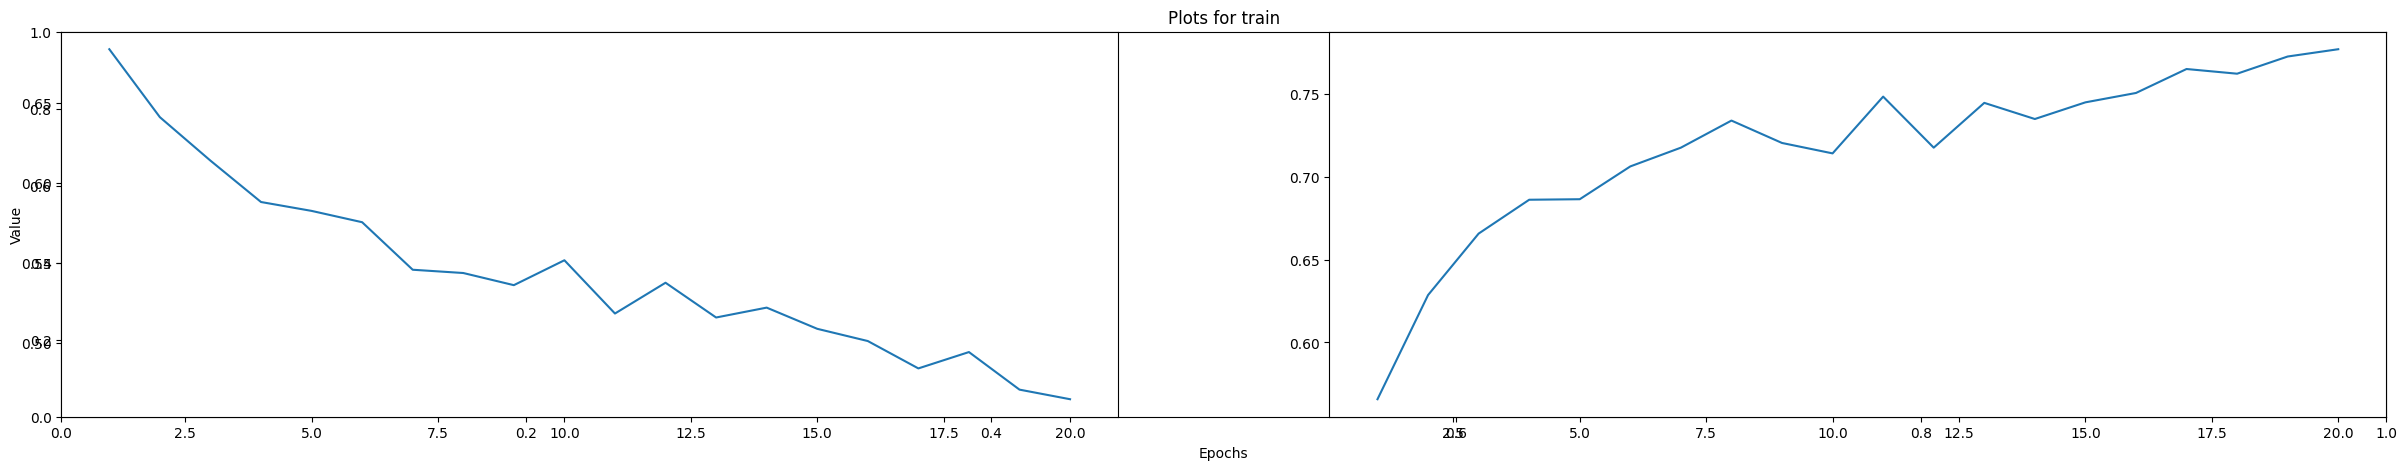

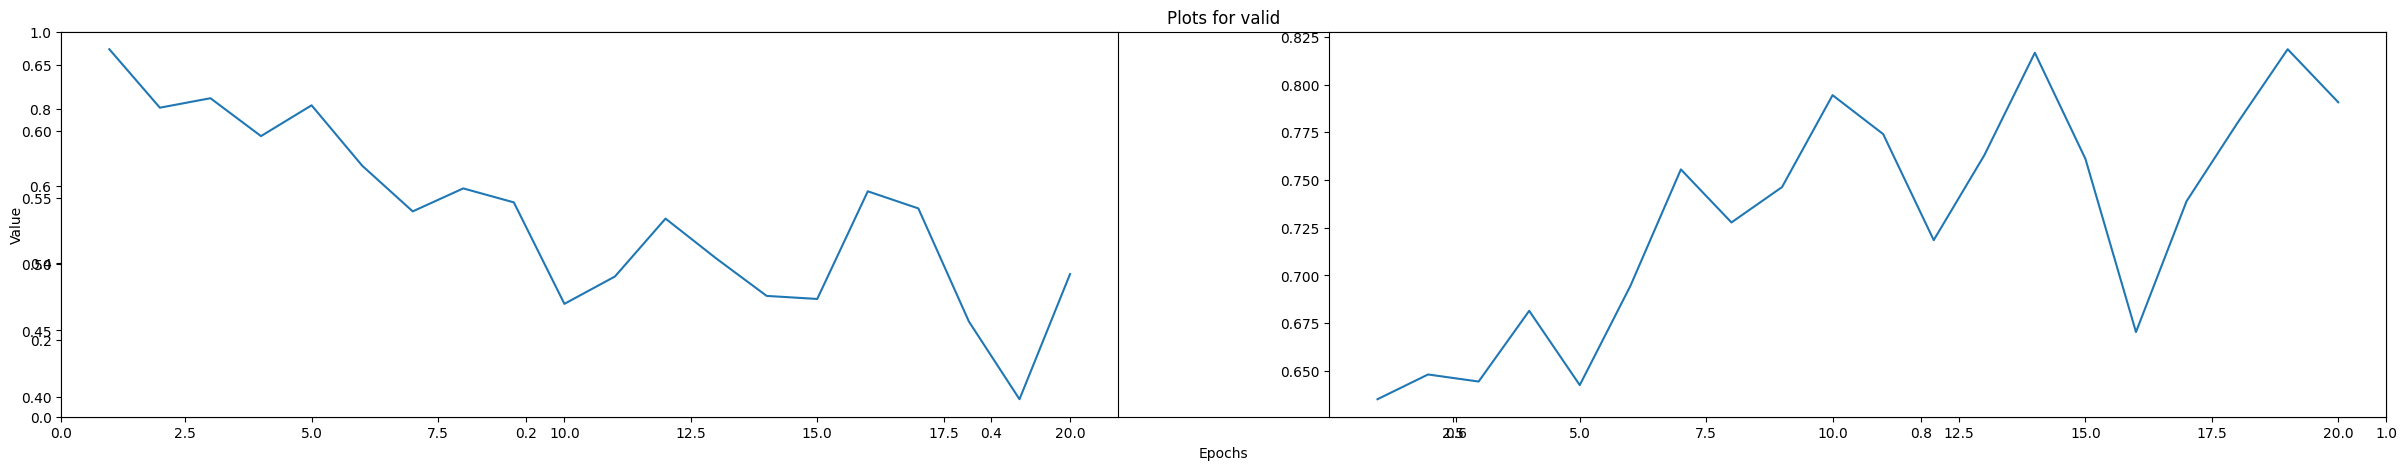

In [81]:
train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 10


C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, train accuracy : 0.7855343818664551, train loss : 0.4420298635959625


C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, val_accuracy : 0.8462963700294495, val_loss : 0.37641260027885437
Epoch : 2, train accuracy : 0.7955973744392395, train loss : 0.4245547354221344
Epoch : 2, val_accuracy : 0.7629629969596863, val_loss : 0.48800286650657654
Epoch : 3, train accuracy : 0.7871068716049194, train loss : 0.4490792155265808
Epoch : 3, val_accuracy : 0.7740740180015564, val_loss : 0.49335020780563354
Epoch : 4, train accuracy : 0.8025156855583191, train loss : 0.42518794536590576
Epoch : 4, val_accuracy : 0.7925925850868225, val_loss : 0.45492368936538696
Epoch : 5, train accuracy : 0.8009430170059204, train loss : 0.4254712462425232
Epoch : 5, val_accuracy : 0.8500000834465027, val_loss : 0.3963324725627899
Epoch : 6, train accuracy : 0.790251612663269, train loss : 0.43768611550331116
Epoch : 6, val_accuracy : 0.7574074268341064, val_loss : 0.4438174366950989
Epoch : 7, train accuracy : 0.8172954320907593, train loss : 0.4017024338245392
Epoch : 7, val_accuracy : 0.833333432674408, val_loss : 0.4

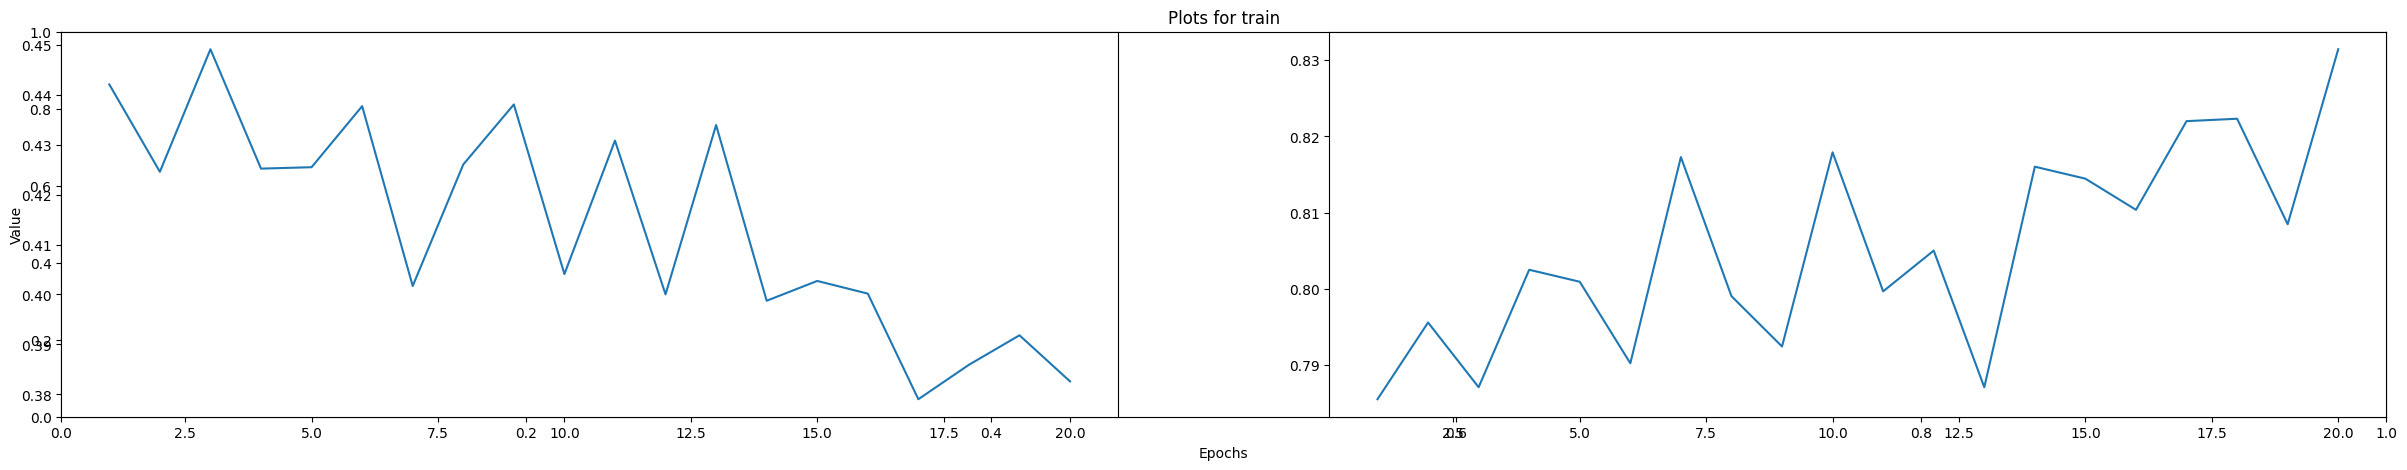

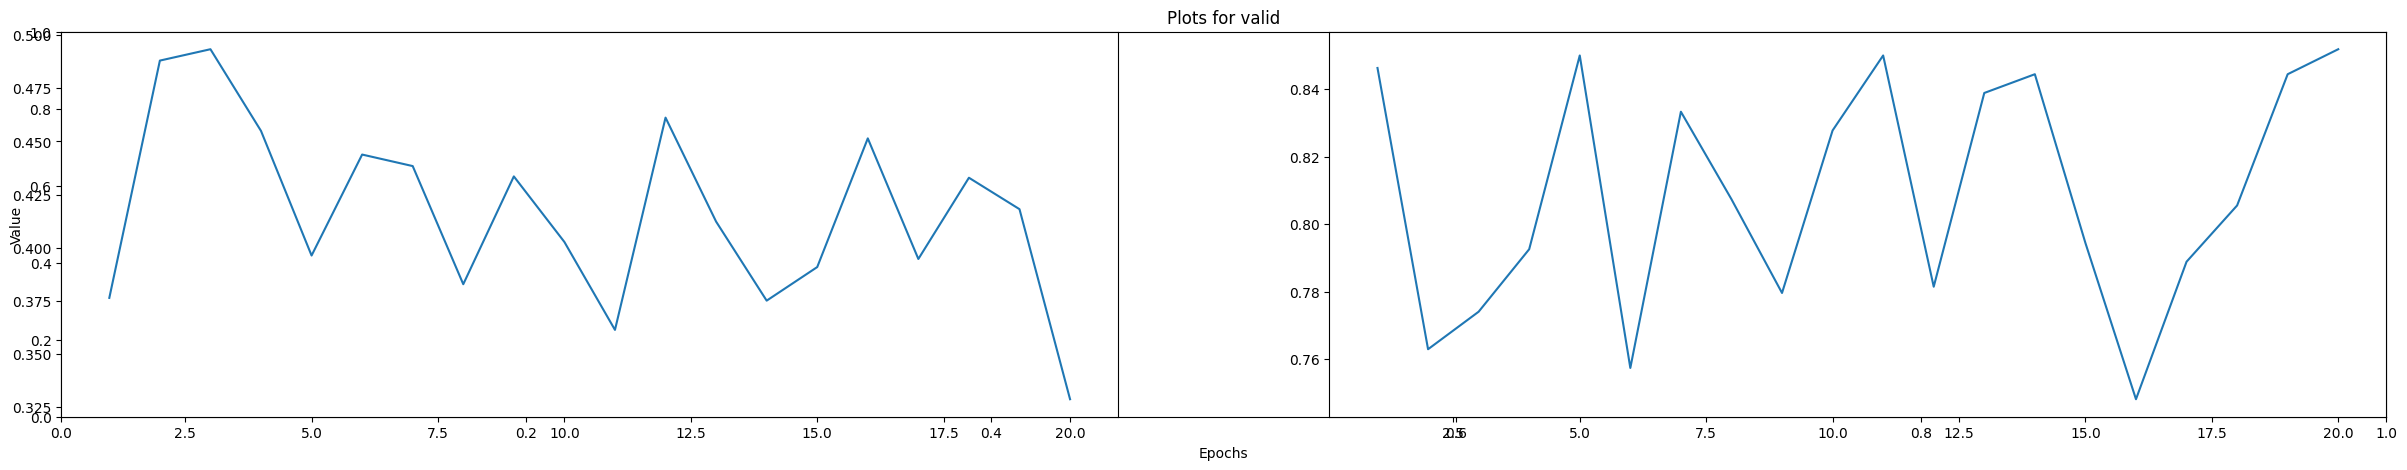

In [82]:
print('Learning rate: 0.0005, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 10


C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, train accuracy : 0.8047167062759399, train loss : 0.40828919410705566


C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, val_accuracy : 0.7796295881271362, val_loss : 0.43181920051574707
Epoch : 2, train accuracy : 0.8201255202293396, train loss : 0.38562795519828796
Epoch : 2, val_accuracy : 0.8185186386108398, val_loss : 0.40181034803390503
Epoch : 3, train accuracy : 0.8144651055335999, train loss : 0.4010138213634491
Epoch : 3, val_accuracy : 0.8444445729255676, val_loss : 0.37747442722320557
Epoch : 4, train accuracy : 0.8311318159103394, train loss : 0.37827980518341064
Epoch : 4, val_accuracy : 0.8777778744697571, val_loss : 0.2994048595428467
Epoch : 5, train accuracy : 0.8100627660751343, train loss : 0.4036262333393097
Epoch : 5, val_accuracy : 0.7925925850868225, val_loss : 0.42349162697792053
Epoch : 6, train accuracy : 0.7949683666229248, train loss : 0.41949716210365295
Epoch : 6, val_accuracy : 0.7740740180015564, val_loss : 0.5272421836853027
Epoch : 7, train accuracy : 0.8066036701202393, train loss : 0.4129355251789093
Epoch : 7, val_accuracy : 0.800000011920929, val_loss : 0

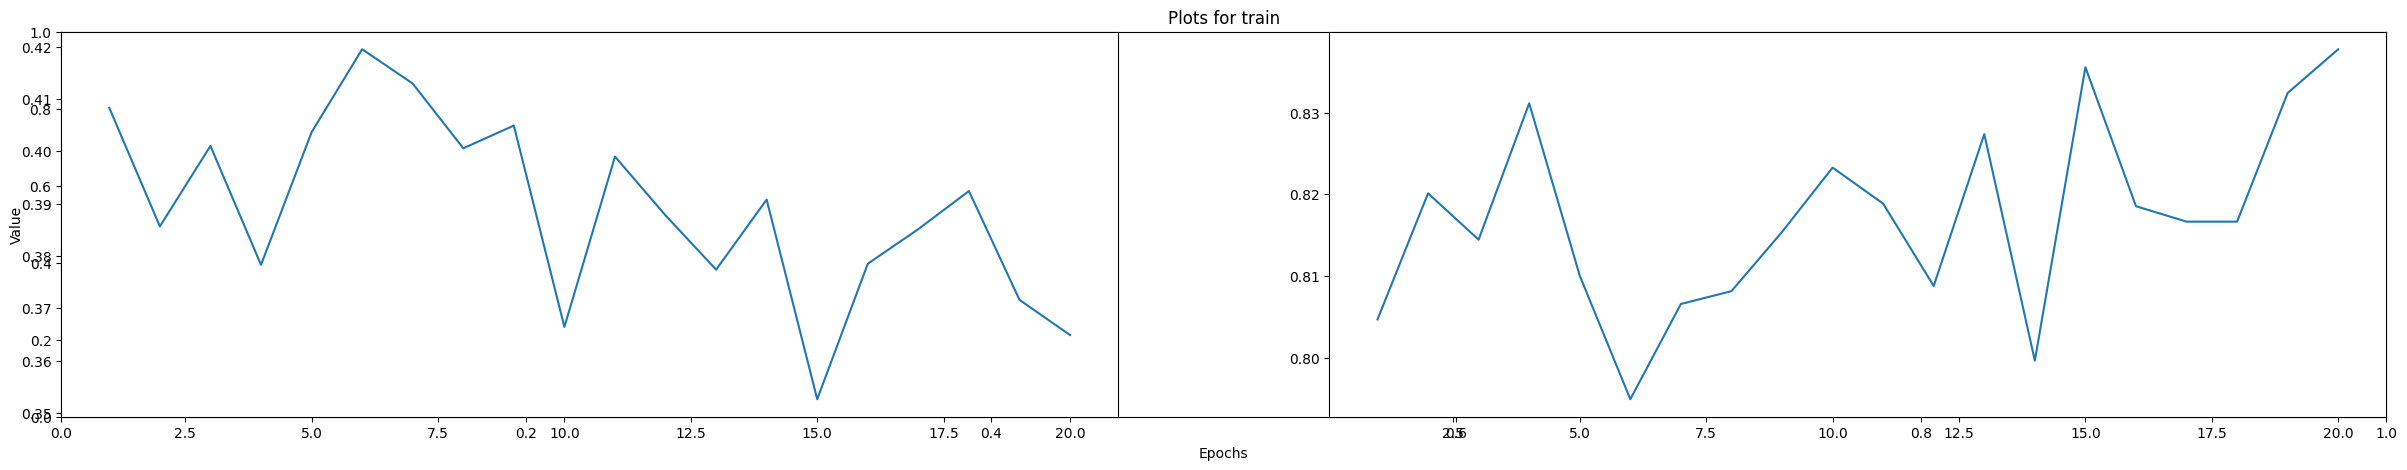

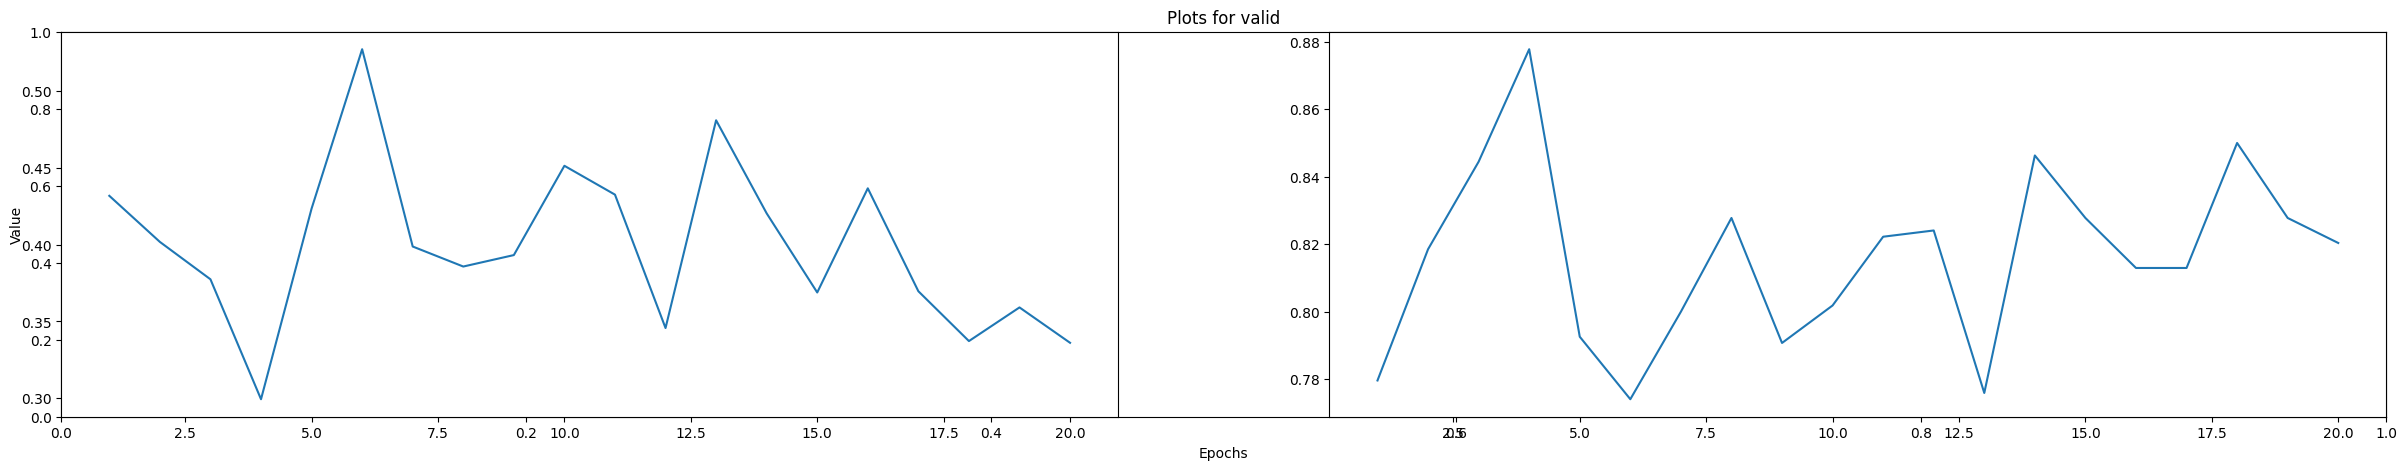

In [83]:
print('Learning rate: 0.0007, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 20


C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, train accuracy : 0.8531249165534973, train loss : 0.3391554355621338


C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, val_accuracy : 0.7847222089767456, val_loss : 0.43819552659988403
Epoch : 2, train accuracy : 0.8393749594688416, train loss : 0.34190529584884644
Epoch : 2, val_accuracy : 0.8500000238418579, val_loss : 0.3225156366825104
Epoch : 3, train accuracy : 0.8368748426437378, train loss : 0.35945239663124084
Epoch : 3, val_accuracy : 0.8652778267860413, val_loss : 0.3387092649936676
Epoch : 4, train accuracy : 0.8193750381469727, train loss : 0.3801226317882538
Epoch : 4, val_accuracy : 0.8236111402511597, val_loss : 0.3498573899269104
Epoch : 5, train accuracy : 0.8381249308586121, train loss : 0.35174646973609924
Epoch : 5, val_accuracy : 0.8194444179534912, val_loss : 0.35626962780952454
Epoch : 6, train accuracy : 0.8243749141693115, train loss : 0.36539220809936523
Epoch : 6, val_accuracy : 0.8375000357627869, val_loss : 0.37115272879600525
Epoch : 7, train accuracy : 0.8431249856948853, train loss : 0.35880765318870544
Epoch : 7, val_accuracy : 0.824999988079071, val_loss : 

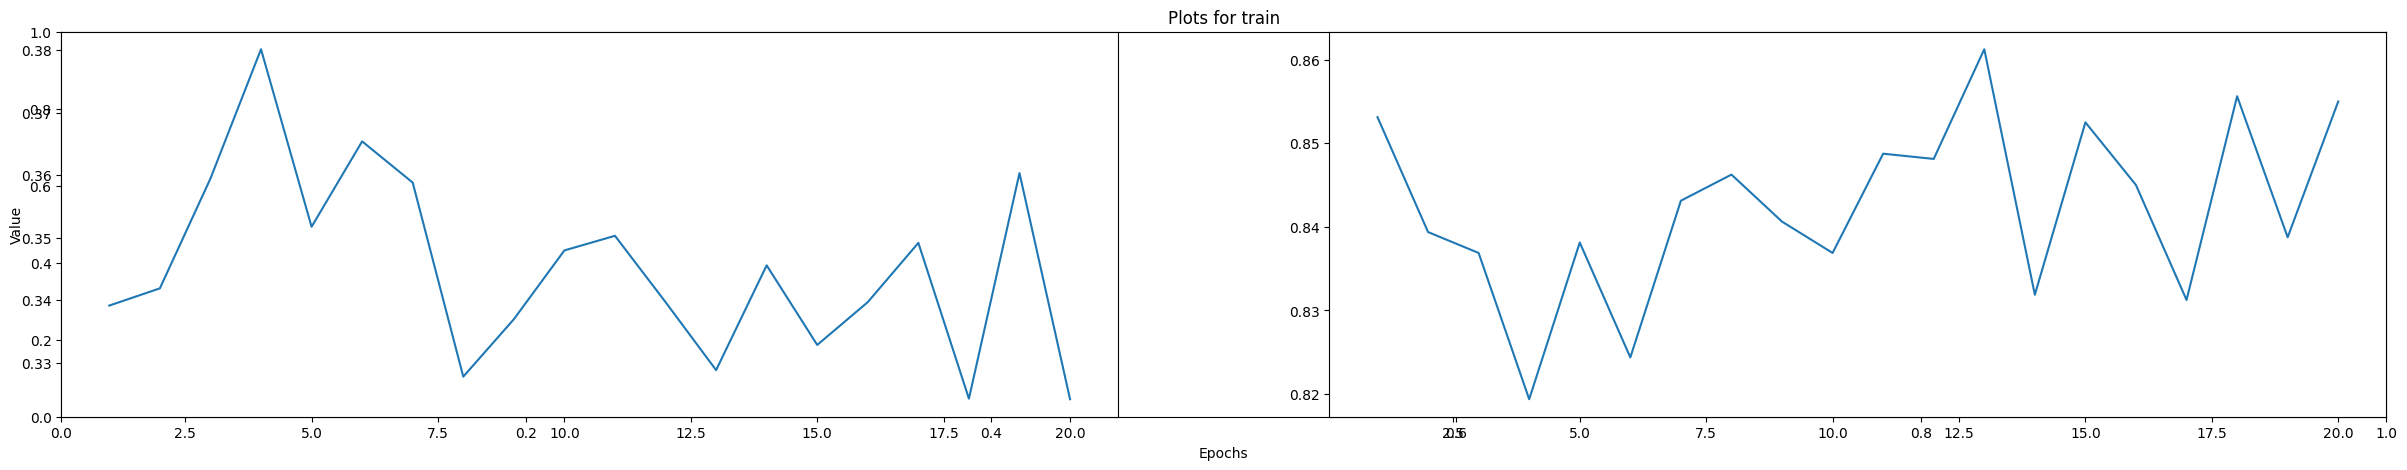

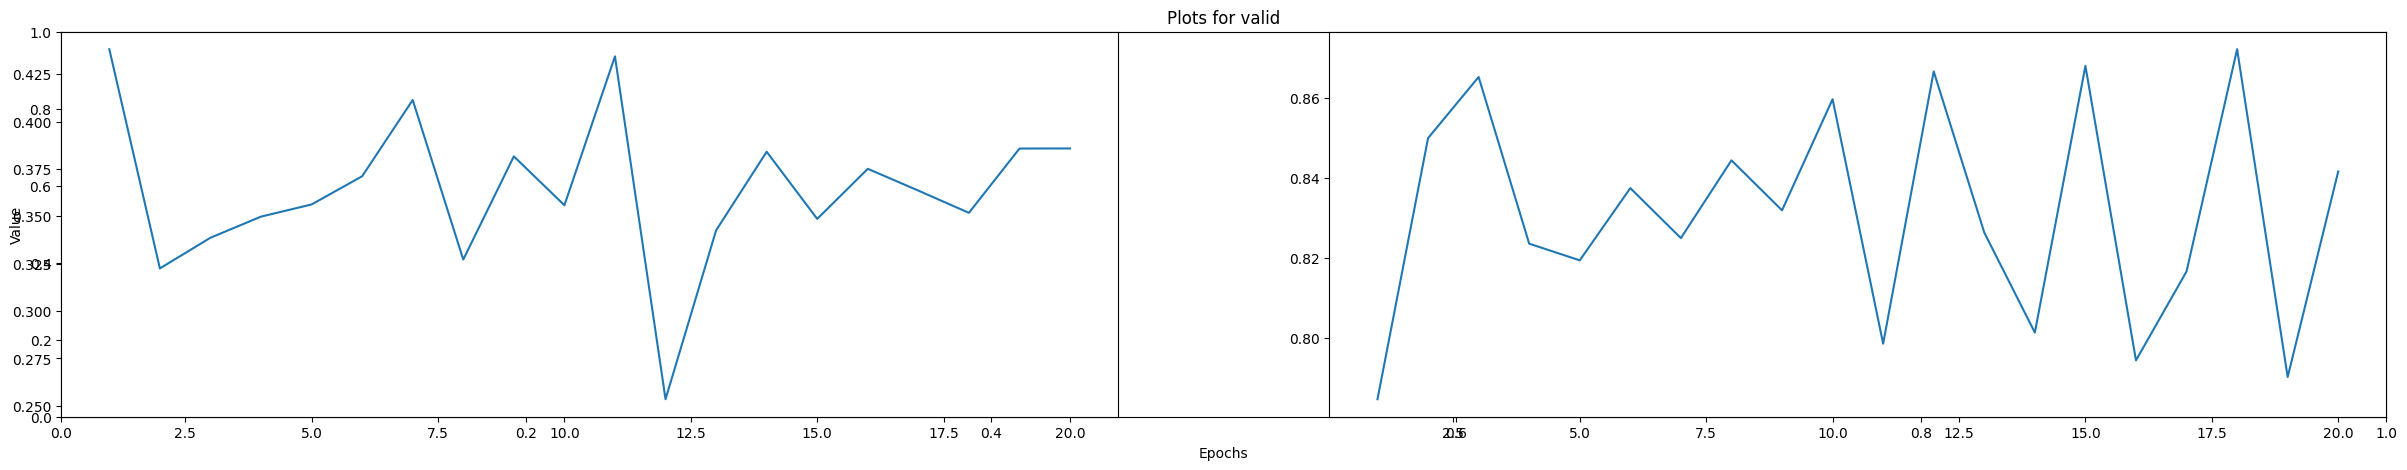

In [84]:
print('Learning rate: 0.001, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 20


C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, train accuracy : 0.8724997043609619, train loss : 0.2951197624206543


C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, val_accuracy : 0.8375000357627869, val_loss : 0.3366064131259918
Epoch : 2, train accuracy : 0.8712500333786011, train loss : 0.2934548556804657
Epoch : 2, val_accuracy : 0.8472222089767456, val_loss : 0.30109572410583496
Epoch : 3, train accuracy : 0.8549999594688416, train loss : 0.3178732693195343
Epoch : 3, val_accuracy : 0.8680555820465088, val_loss : 0.34005099534988403
Epoch : 4, train accuracy : 0.8656248450279236, train loss : 0.28827300667762756
Epoch : 4, val_accuracy : 0.8277777433395386, val_loss : 0.3984442353248596
Epoch : 5, train accuracy : 0.8543748259544373, train loss : 0.3166896104812622
Epoch : 5, val_accuracy : 0.8402777910232544, val_loss : 0.3387289047241211
Epoch : 6, train accuracy : 0.8618748784065247, train loss : 0.29991766810417175
Epoch : 6, val_accuracy : 0.8138889074325562, val_loss : 0.36334002017974854
Epoch : 7, train accuracy : 0.8718748688697815, train loss : 0.2877919375896454
Epoch : 7, val_accuracy : 0.8472222089767456, val_loss : 0.

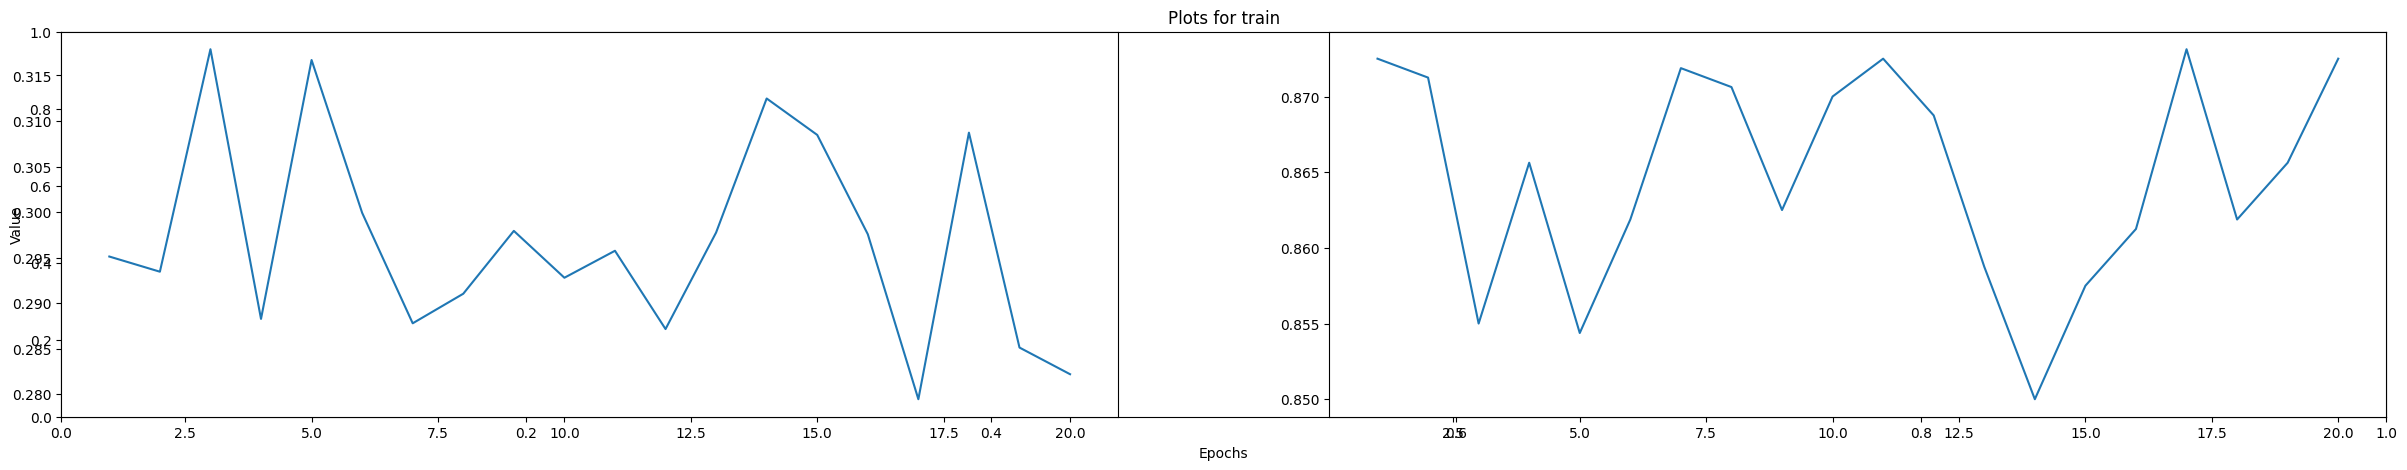

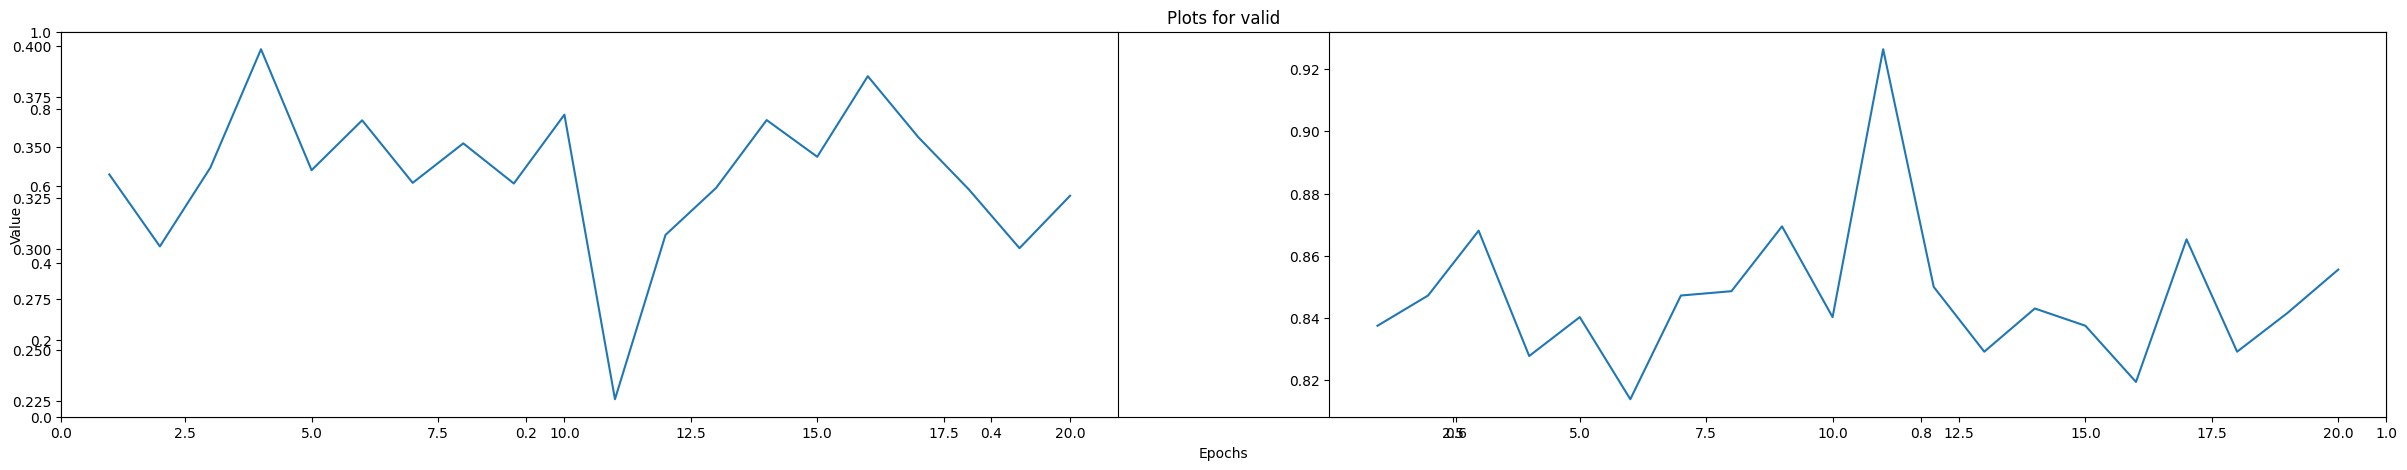

In [85]:
print('Learning rate: 0.0005, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 20


C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, train accuracy : 0.8606250286102295, train loss : 0.292625367641449


C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, val_accuracy : 0.8638888597488403, val_loss : 0.2736910283565521
Epoch : 2, train accuracy : 0.8599997758865356, train loss : 0.3128661513328552
Epoch : 2, val_accuracy : 0.824999988079071, val_loss : 0.3714374601840973
Epoch : 3, train accuracy : 0.859375, train loss : 0.31024444103240967
Epoch : 3, val_accuracy : 0.8861111402511597, val_loss : 0.279773086309433
Epoch : 4, train accuracy : 0.8712499141693115, train loss : 0.2857697308063507
Epoch : 4, val_accuracy : 0.8458333611488342, val_loss : 0.3253743648529053
Epoch : 5, train accuracy : 0.8774998188018799, train loss : 0.27617377042770386
Epoch : 5, val_accuracy : 0.8249999284744263, val_loss : 0.359305739402771
Epoch : 6, train accuracy : 0.8668748736381531, train loss : 0.2986495792865753
Epoch : 6, val_accuracy : 0.8944444060325623, val_loss : 0.2859644293785095
Epoch : 7, train accuracy : 0.8606248497962952, train loss : 0.2978611886501312
Epoch : 7, val_accuracy : 0.8708333373069763, val_loss : 0.3238692879676819

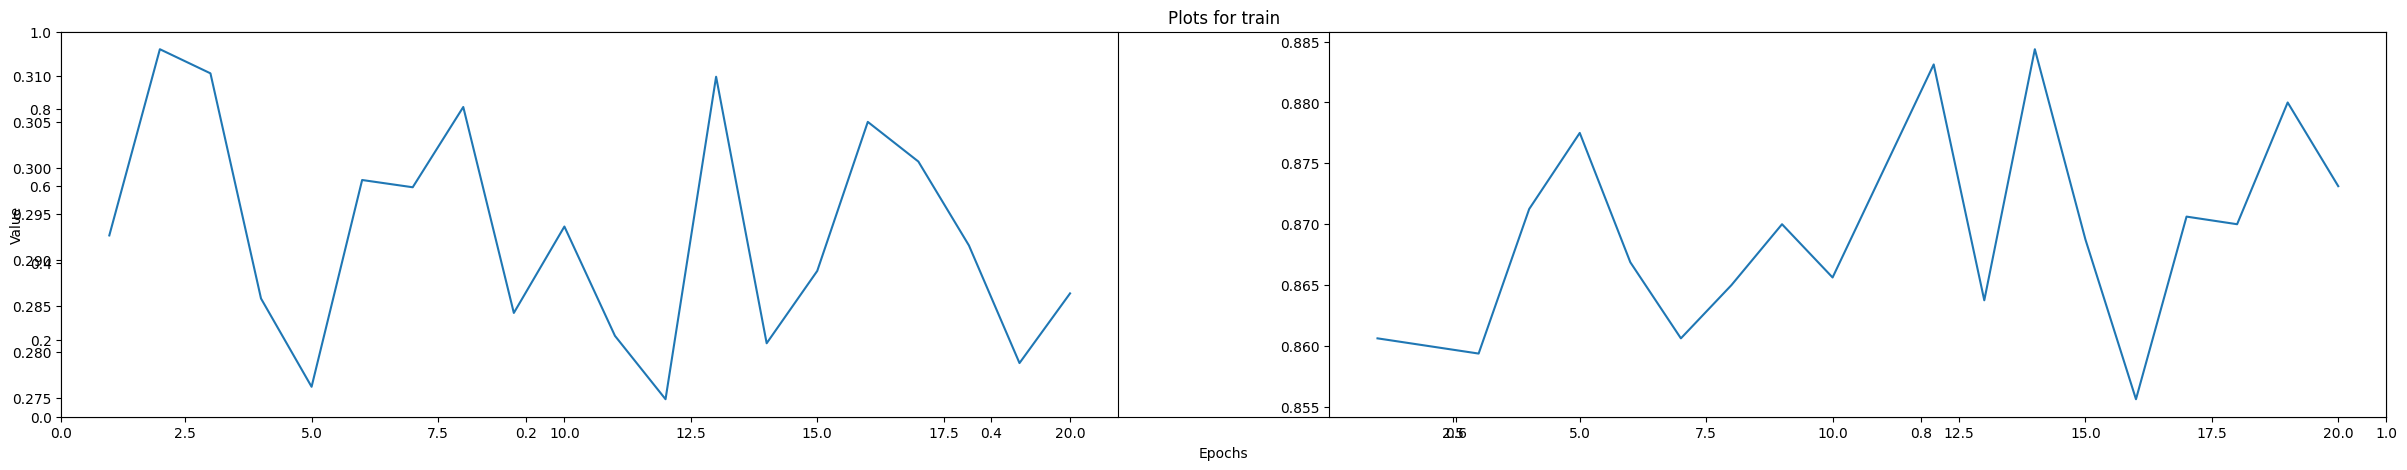

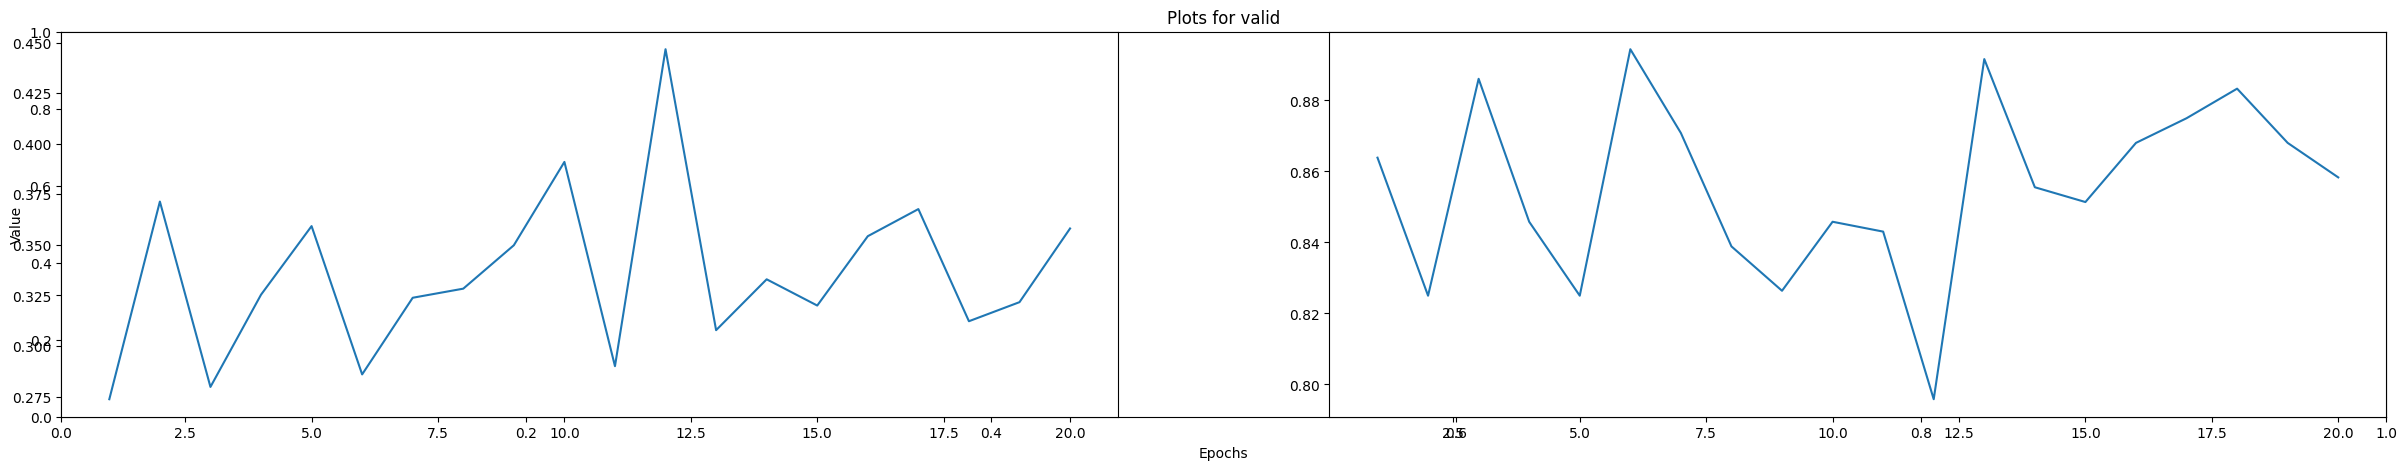

In [86]:
print('Learning rate: 0.0007, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 50


C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, train accuracy : 0.8738234639167786, train loss : 0.2812645137310028


C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, val_accuracy : 0.876153826713562, val_loss : 0.30646803975105286
Epoch : 2, train accuracy : 0.8828675746917725, train loss : 0.25506433844566345
Epoch : 2, val_accuracy : 0.8561538457870483, val_loss : 0.2970984876155853
Epoch : 3, train accuracy : 0.8903674483299255, train loss : 0.2612287104129791
Epoch : 3, val_accuracy : 0.8865385055541992, val_loss : 0.34231987595558167
Epoch : 4, train accuracy : 0.8813233375549316, train loss : 0.2684878706932068
Epoch : 4, val_accuracy : 0.8569230437278748, val_loss : 0.3110772371292114
Epoch : 5, train accuracy : 0.8825367093086243, train loss : 0.264536589384079
Epoch : 5, val_accuracy : 0.8903845548629761, val_loss : 0.2763397991657257
Epoch : 6, train accuracy : 0.8725736141204834, train loss : 0.28582561016082764
Epoch : 6, val_accuracy : 0.876153826713562, val_loss : 0.2833338677883148
Epoch : 7, train accuracy : 0.9019116759300232, train loss : 0.24563880264759064
Epoch : 7, val_accuracy : 0.8665385246276855, val_loss : 0.324

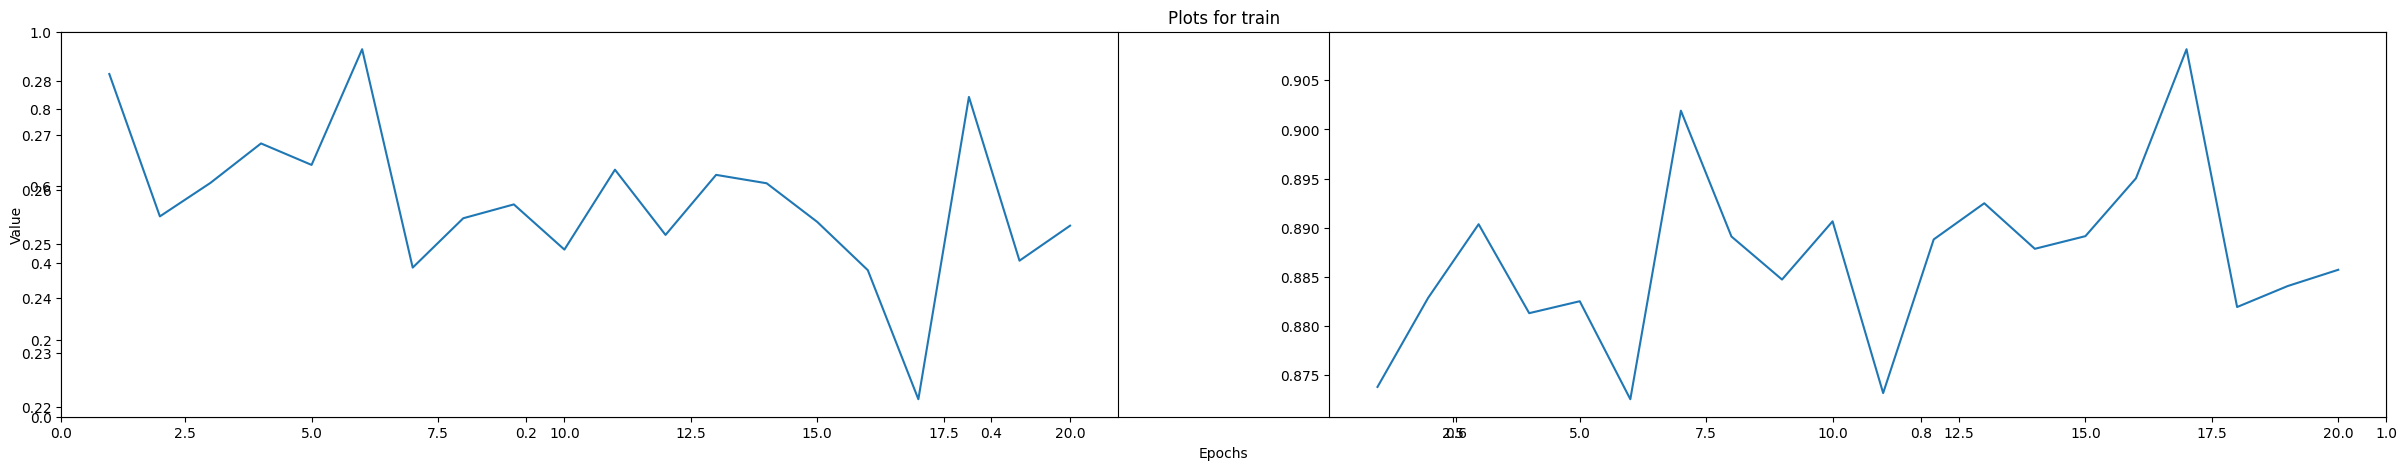

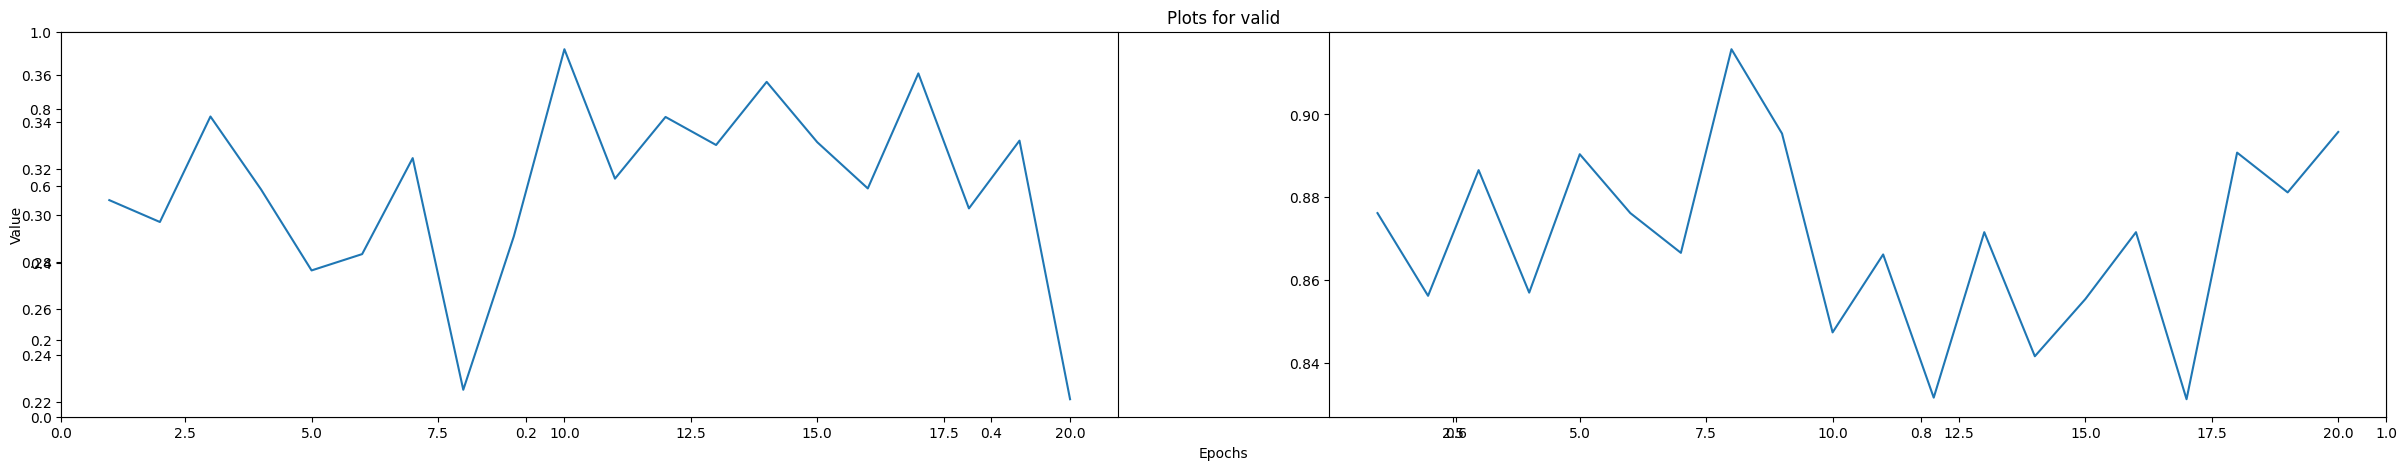

In [87]:
print('Learning rate: 0.001, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 50


C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, train accuracy : 0.8928676247596741, train loss : 0.239694282412529


C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, val_accuracy : 0.876153826713562, val_loss : 0.35697034001350403
Epoch : 2, train accuracy : 0.8988234400749207, train loss : 0.2230549454689026
Epoch : 2, val_accuracy : 0.8861538171768188, val_loss : 0.2803122401237488
Epoch : 3, train accuracy : 0.9084924459457397, train loss : 0.21256014704704285
Epoch : 3, val_accuracy : 0.8607692122459412, val_loss : 0.30444443225860596
Epoch : 4, train accuracy : 0.8988234996795654, train loss : 0.21472883224487305
Epoch : 4, val_accuracy : 0.8561538457870483, val_loss : 0.38083362579345703
Epoch : 5, train accuracy : 0.9081615805625916, train loss : 0.2243671864271164
Epoch : 5, val_accuracy : 0.9007692337036133, val_loss : 0.21582384407520294
Epoch : 6, train accuracy : 0.9112867116928101, train loss : 0.21696646511554718
Epoch : 6, val_accuracy : 0.8526922464370728, val_loss : 0.3536854684352875
Epoch : 7, train accuracy : 0.895367443561554, train loss : 0.23742897808551788
Epoch : 7, val_accuracy : 0.9149999618530273, val_loss : 0

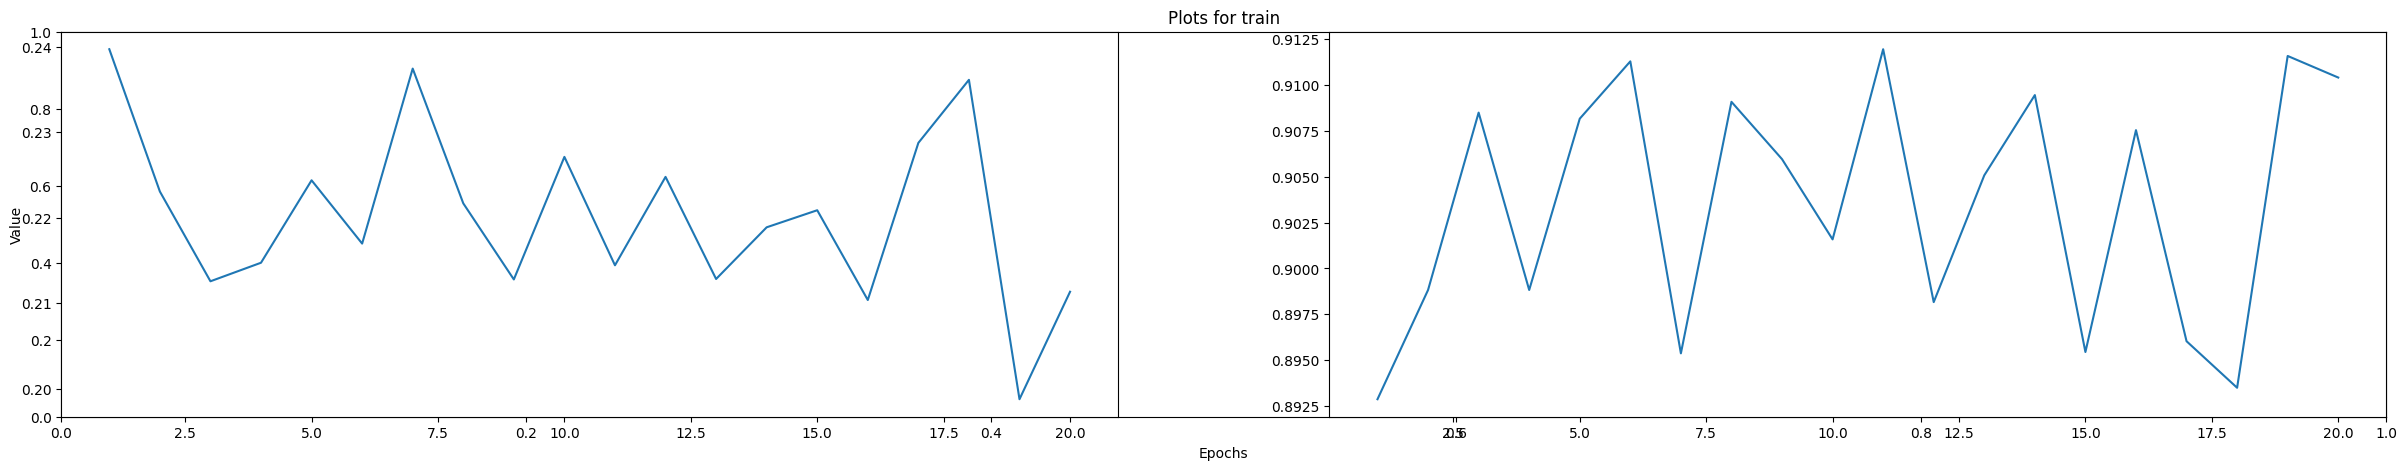

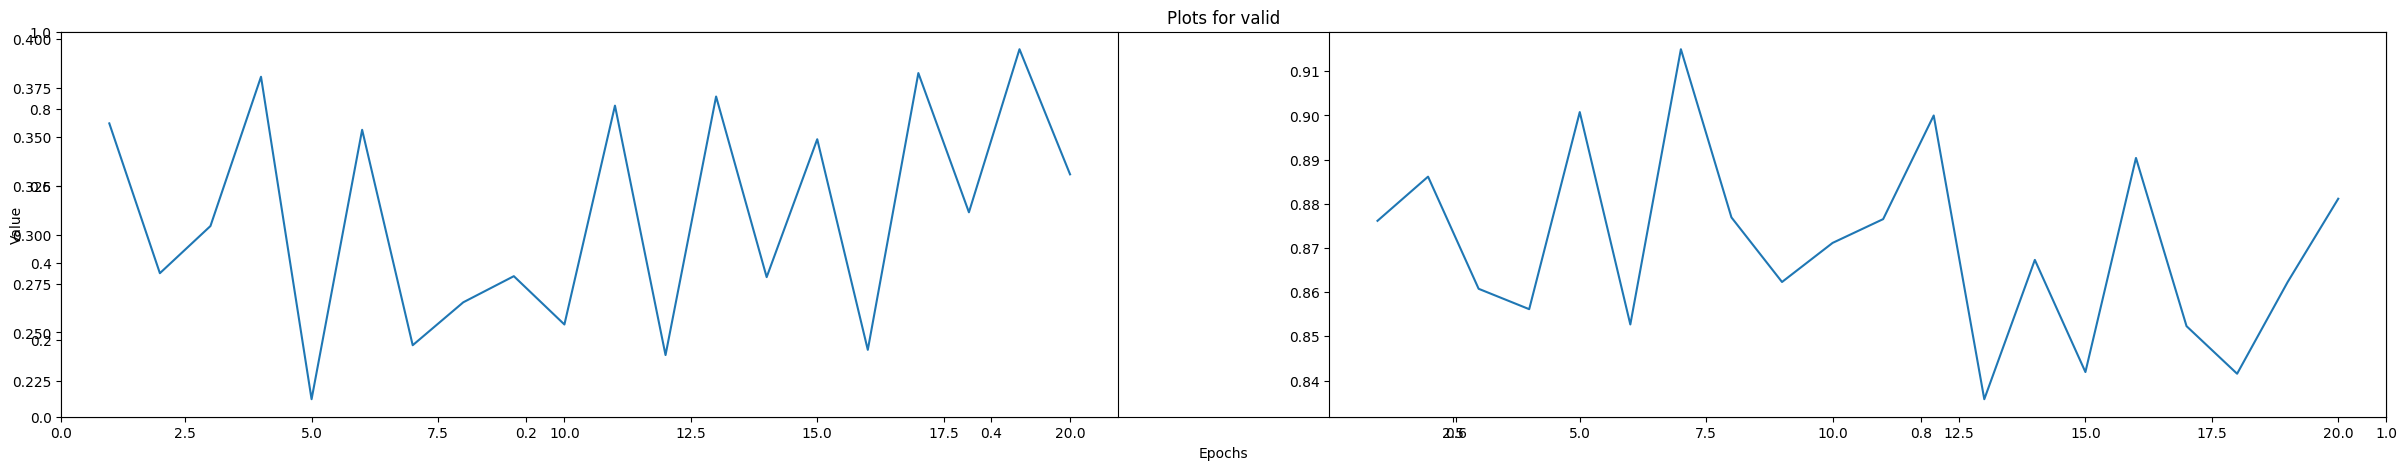

In [88]:
print('Learning rate: 0.0005, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 50


C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, train accuracy : 0.8956984281539917, train loss : 0.24501299858093262


C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, val_accuracy : 0.8323076963424683, val_loss : 0.4119489789009094
Epoch : 2, train accuracy : 0.9109557271003723, train loss : 0.20747573673725128
Epoch : 2, val_accuracy : 0.8665385246276855, val_loss : 0.34262776374816895
Epoch : 3, train accuracy : 0.899742603302002, train loss : 0.22657200694084167
Epoch : 3, val_accuracy : 0.8919230699539185, val_loss : 0.26872432231903076
Epoch : 4, train accuracy : 0.9103675484657288, train loss : 0.20869499444961548
Epoch : 4, val_accuracy : 0.8615384101867676, val_loss : 0.3126826882362366
Epoch : 5, train accuracy : 0.903529167175293, train loss : 0.21794375777244568
Epoch : 5, val_accuracy : 0.8123077154159546, val_loss : 0.34265679121017456
Epoch : 6, train accuracy : 0.9022425413131714, train loss : 0.2262609899044037
Epoch : 6, val_accuracy : 0.8715384006500244, val_loss : 0.26855912804603577
Epoch : 7, train accuracy : 0.894117534160614, train loss : 0.2415267527103424
Epoch : 7, val_accuracy : 0.8857691884040833, val_loss : 0.

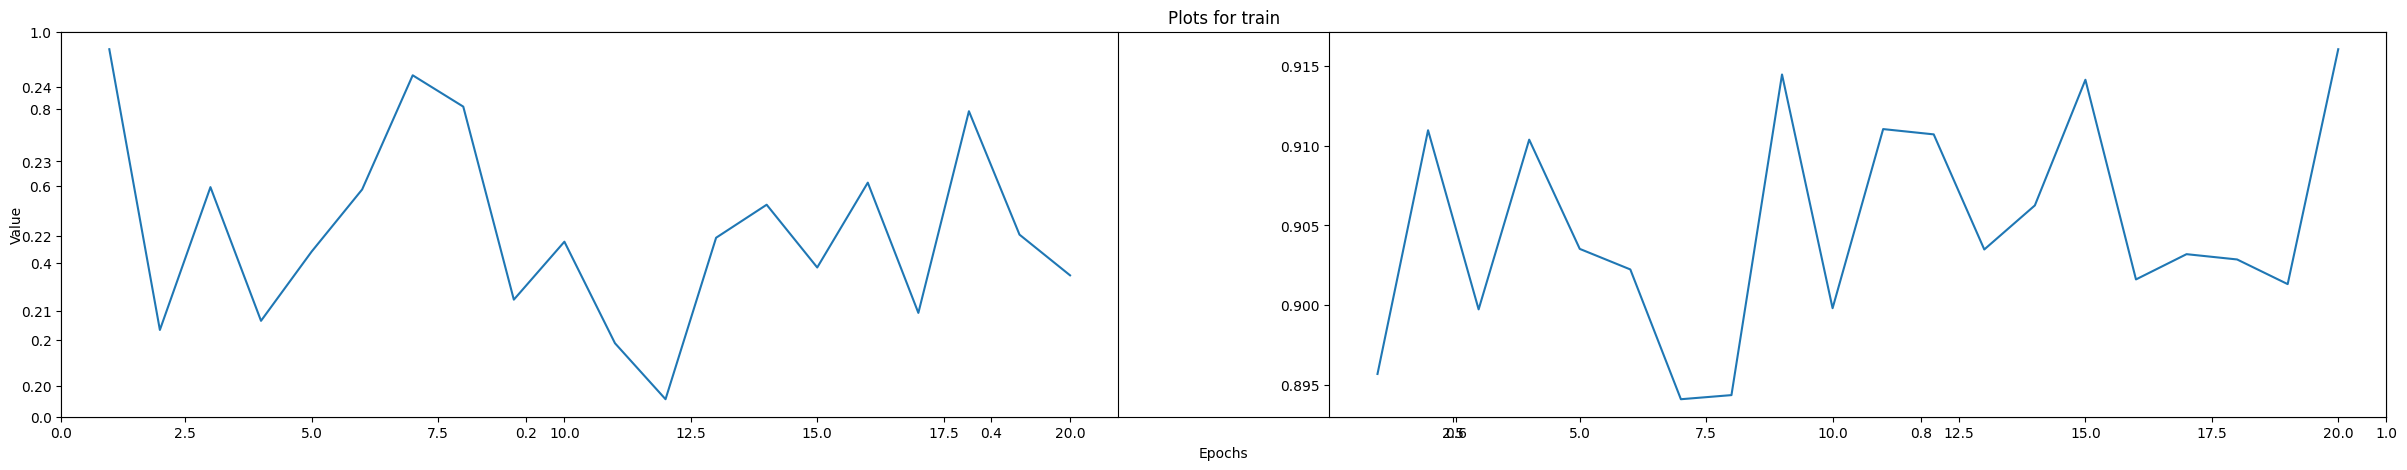

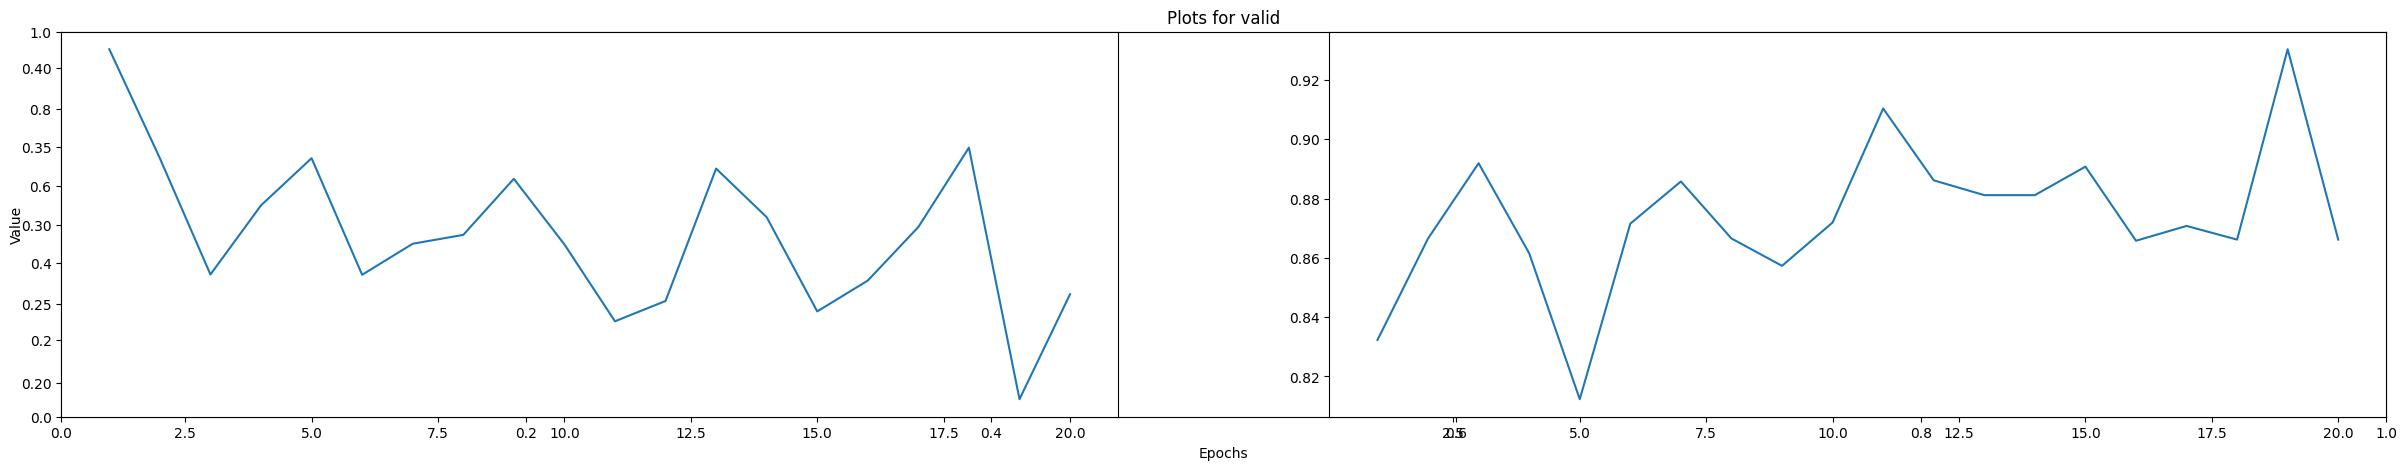

In [89]:
print('Learning rate: 0.0007, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)